In [1]:
%matplotlib inline
%reload_ext autoreload

In [2]:
from numba import cuda


cuda.detect()

Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 3090'                              [SUPPORTED]
                      compute capability: 8.6
                           pci device id: 0
                              pci bus id: 101
Summary:
	1/1 devices are supported


True

In [3]:
%conda list replay_trajectory_classification

# packages in environment at /home/edeno/miniconda3/envs/pose_analysis:
#
# Name                    Version                   Build  Channel
replay_trajectory_classification 0.9.11.dev0        pyh7b7c402_0    edeno

Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

import logging
import sys

def setup_logging(epoch_key, date_format='%d-%b-%y %H:%M:%S', format='%(asctime)s %(message)s'):
    animal, day, epoch = epoch_key
    log_filename = f"{animal}_{day:02d}_{epoch:02d}_test_speed_gpu.log"

    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter(fmt=format, datefmt=date_format)

    stdout_handler = logging.StreamHandler(sys.stdout)
    stdout_handler.setLevel(logging.INFO)
    stdout_handler.setFormatter(formatter)

    file_handler = logging.FileHandler(log_filename)
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)

    logger.addHandler(file_handler)
    logger.addHandler(stdout_handler)

sns.set_context("talk")

In [5]:
epoch_key = 'Jaq', 3, 12

In [6]:
setup_logging(epoch_key)

In [7]:
from src.load_data import load_data

logging.info('GPU likelihood + State Space')
data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=5,
                 min_distance_traveled=30)

28-Sep-21 17:11:54 GPU likelihood + State Space
28-Sep-21 17:11:54 Loading position info...
28-Sep-21 17:12:26 Loading multiunit...
28-Sep-21 17:12:48 Loading spikes...
28-Sep-21 17:14:03 Finding ripple times...


#### GPU

In [8]:
from replay_trajectory_classification import ClusterlessClassifier
from src.parameters import WTRACK_EDGE_ORDER, WTRACK_EDGE_SPACING
import pprint

continuous_transition_types = (
    [['random_walk', 'uniform'],
     ['uniform',     'uniform']])


clusterless_algorithm = 'multiunit_likelihood_gpu'
clusterless_algorithm_params = {
    'mark_std': 20.0,
    'position_std': 8.0,
}

classifier_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'continuous_transition_types': continuous_transition_types,
    'discrete_transition_diag': 0.968,
    'clusterless_algorithm': clusterless_algorithm,
    'clusterless_algorithm_params': clusterless_algorithm_params
}

logging.info(pprint.pprint(classifier_parameters))

{'clusterless_algorithm': 'multiunit_likelihood_gpu',
 'clusterless_algorithm_params': {'mark_std': 20.0, 'position_std': 8.0},
 'continuous_transition_types': [['random_walk', 'uniform'],
                                 ['uniform', 'uniform']],
 'discrete_transition_diag': 0.968,
 'movement_var': 6.0,
 'place_bin_size': 2.5,
 'replay_speed': 1}
28-Sep-21 17:14:37 None


In [9]:
from numba import cuda

cuda.synchronize()

In [10]:
state_names = ['Continuous', 'Fragmented']

classifier = ClusterlessClassifier(**classifier_parameters)
classifier.fit(
    position=data["position_info"].linear_position,
    multiunits=data["multiunits"],
    track_graph=data["track_graph"],
    edge_order=WTRACK_EDGE_ORDER,
    edge_spacing=WTRACK_EDGE_SPACING,
)

results_gpu_likelihood = classifier.predict(
    data["multiunits"],
    time=data["position_info"].index / np.timedelta64(1, "s"),
    state_names=state_names,
    use_gpu=True
)
logging.info('Done...')

28-Sep-21 17:14:37 Fitting initial conditions...
28-Sep-21 17:14:37 Fitting state transition...
28-Sep-21 17:14:37 Fitting multiunits...
28-Sep-21 17:14:41 Estimating likelihood...
28-Sep-21 18:34:33 Estimating causal posterior...
28-Sep-21 18:38:01 Estimating acausal posterior...
28-Sep-21 18:45:35 Done...


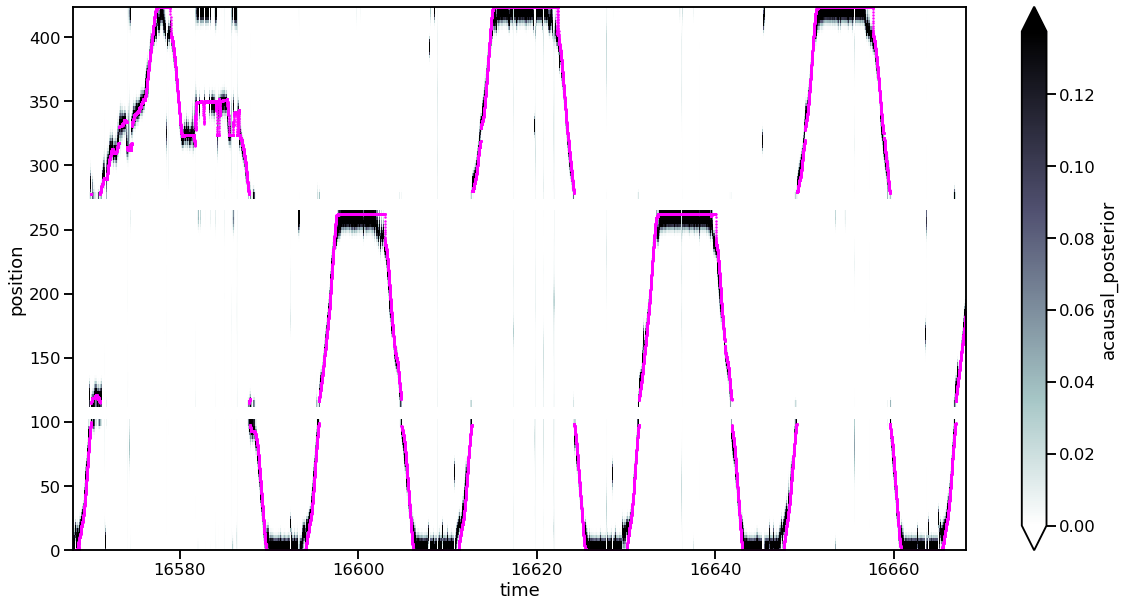

In [11]:
import matplotlib.pyplot as plot

time_slice = slice(100_000, 150_000)

(results_gpu_likelihood
 .acausal_posterior
 .sum('state')
 .isel(time=time_slice)
 .plot(x='time', y='position', robust=True, size=10, aspect=2, cmap='bone_r'))

plt.scatter(data['position_info'].iloc[time_slice].index / np.timedelta64(1, 's'),
         data['position_info'].iloc[time_slice].linear_position,
         color='magenta', s=1)